
# Determining likelihood of no-shows to medical appointments in Brazil 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> In this project, I'll explore a dataset of no-show medical appointments in Brazil. The  dataset was originally published on Kaggle by [Joni Hoppen](https://www.kaggle.com/joniarroba "JoniHoppen") and can be found [here](https://www.kaggle.com/joniarroba/noshowappointments "here"). The main question that this dataset raises is whether it is possible to predict the likelihood of no-show appointments based on determining factors, such as the patients' medical conditions and demographic information, the extent of time between the scheduled day and the appointment day, the day and time of the appointment itself. I'm specifically interested in knowing whether gender and age were determining factors of no-show appointments. I also want to explore the effect of time on the likelihood of no-shows to medical appointments.

> A few notes about the dataset:
* 'scheduled_day' is the day on which the person scheduled the appointment & 'appointment_day' is the day of the actual medical visit.
* 'neighborhood' indicates the location of the hospital.
* ‘scholarship’ indicates whether or not the patient is enrolled in the Brasilian welfare system known as Programa Bolsa Família, introduced in 2003 by former president Lula da Silva. You can read more about the program [here](https://www.centreforpublicimpact.org/case-study/bolsa-familia-in-brazil/ "here"). A score of 1 means that the person received aid under the welfare program, whereas a score of 0 means that the person did not.
* The last column of the dataset, 'no_show', is encoded such that a "No" indicates that the person showed up for his/her/their medical appointment and a "Yes" indicates that the person did not show up.

> Now that we've provided a bit of context, let's start by importing the necessary packages for the analysis.

In [2]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

> Let's now load the dataset and print a few lines to visualize how the data is structured.

In [267]:
no_show_df = pd.read_csv('noshowappt.csv')

In [268]:
no_show_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [269]:
no_show_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


<a id='wrangling'></a>
## Data Wrangling



> As we notice from the printed data, it looks like the column names aren't uniform. Let's rename the columns so that they are all printed in lowercase. If the column name contains two words, let's also separate them using an underscore.

In [270]:
# Renaming columns

no_show_df.rename(columns=lambda x: x.strip().lower().replace('-', '_'), inplace=True)


no_show_df.rename(columns={'patientid':'patient_id',
                   'appointmentid':'appointment_id',
                  'scheduledday':'scheduled_day',
                  'appointmentday':'appointment_day',
                  'hipertension':'hypertension',
                  'handcap':'handicap'}, 
          inplace=True)

no_show_df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


> We also notice from the dataset summary that the datatype of columns 'scheduled_day' and 'appointment_day' appears to be an object, representing text or a combination of numeric and non-numeric values, even though the columns seem to be of datetime datatype. Let's convert the datatype from object to datetime.

In [271]:
#changing datatype of columns 'scheduled_day' and 'appointment_day'

no_show_df['scheduled_day'] = pd.to_datetime(no_show_df['scheduled_day'], format='%Y-%m-%d %H:%M:%S')
no_show_df['appointment_day'] = pd.to_datetime(no_show_df['appointment_day'], format='%Y-%m-%d')

no_show_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null float64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null datetime64[ns, UTC]
appointment_day    110527 non-null datetime64[ns, UTC]
age                110527 non-null int64
neighbourhood      110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: datetime64[ns, UTC](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


> As we see from the dataset summary, the columns 'scheduled_day' and 'appointment_day' have now been changed to a datetime datatype. Let's now investigate the 'age' column. Let's first sort the rows by ascending age values and investigate low and high age values.

In [272]:
no_show_df.sort_values(by=['age'], inplace=True)

In [273]:
no_show_df[(no_show_df.age < 0) | (no_show_df.age > 100)]

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
99832,4.659432e+14,5775010,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,0,0,0,No
90372,2.342836e+11,5751563,F,2016-05-31 10:19:49+00:00,2016-06-02 00:00:00+00:00,102,MARIA ORTIZ,0,0,0,0,0,0,No
58014,9.762948e+14,5651757,F,2016-05-03 09:14:53+00:00,2016-05-03 00:00:00+00:00,102,CONQUISTA,0,0,0,0,0,0,No
63915,3.196321e+13,5700279,F,2016-05-16 09:17:44+00:00,2016-05-19 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,F,2016-05-30 09:44:51+00:00,2016-05-30 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,No
68127,3.196321e+13,5562812,F,2016-04-08 14:29:17+00:00,2016-05-16 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes
63912,3.196321e+13,5700278,F,2016-05-16 09:17:44+00:00,2016-05-19 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes
97666,7.482346e+14,5717451,F,2016-05-19 07:57:56+00:00,2016-06-03 00:00:00+00:00,115,SÃO JOSÉ,0,1,0,0,0,1,No


> From the query above, it looks like there are 8 rows with age values below 0 and above 100. We can also confirm with a boxplot the age dispersion for both women and men.

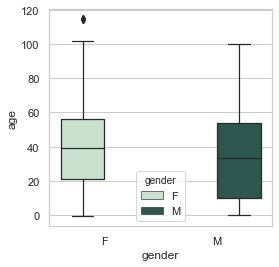

In [274]:
plt.figure(figsize=(4,4))
sns.boxplot(x = 'gender', y="age", hue='gender', palette = 'ch:2.5,-.2,dark=.3', data=no_show_df, linewidth=1.25);

> Based on the table above, the age value of 102 doesn't seem particularly bothersome: advancements in the medical field have led to an increase in life expectancy over time, making centenarians more common now than before. However, there are two other datapoints in this query that don't quite match our expectations. 

> First, it's a bit hard to imagine that someone below the age of 0 would have an appointment unless it's a prenatal medical appointment. Because of the lack of documentation around that particular datapoint, let's delete that entire row from the dataset to avoid skewing the data. We also notice that there seems to be two supercentanarians (based on the patient ID) with an age of 115! According to the [Gerontology Research Group](http://www.grg.org/SC/WorldSCRankingsList.html "Gerontology Research Group"), there were only 5 Brazilian supercentanarians and all died before even reaching the age of 115. It's possible that the 2 supercentanarians who scheduled a medical visit weren't Brazilian nationals but foreign nationals residing in Brazil. To avoid skewing the results derived from statistical analysis, and given the lack of documentation to determine the validity of the datapoints, let's remove these 5 rows altogether.

In [275]:
no_show_df = no_show_df[(no_show_df.age > 0) & (no_show_df.age < 115)]

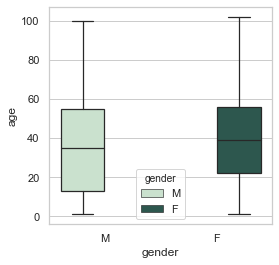

In [276]:
plt.figure(figsize=(4,4))
sns.boxplot(x='gender', y="age", hue='gender', palette = 'ch:2.5,-.2,dark=.3', data=no_show_df, linewidth=1.25);


> While I was working on the Exploratory Data Analysis section, I realized by doing a timedelta between the 'appointment_day' and 'scheduled_day' columns that there were appointments scheduled after the appointment date itself. Of course the dataset would record a "no-show" for those appointments! I am not sure what led to the presence of such incorrect information, whether the system encountered a bug or the data was simply poorly entered into the database. Regardless, I decided to remove those rows to avoid misrepresenting no-show appointment data.

In [277]:
no_show_df['timedelta'] =  (no_show_df['scheduled_day'] - no_show_df['appointment_day']).dt.days
no_show_df = no_show_df[(no_show_df.timedelta <= 0)]


> Now that we've sanitized the data, let's start exploring the questions first asked in the introduction section of this analysis.

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1: Are gender and age determining factors of no-show appointments?

> Let's start by exploring the overall proportion of no-show appointments, broken down by gender.

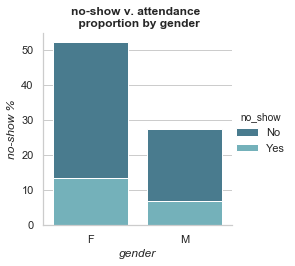

In [278]:
overall_no_show = no_show_df.groupby(['gender','no_show'], as_index = False)['patient_id'].count()
overall_no_show['%'] = overall_no_show['patient_id']/overall_no_show['patient_id'].sum()*100
overall_no_show

sns.set(style="whitegrid");
overall_noshow_plot = sns.catplot(x="gender", y="%", hue = 'no_show', data=overall_no_show,
                height=3.5, kind="bar", palette="GnBu_d", dodge=False);

plt.title('no-show v. attendance \n proportion by gender', fontweight = 'bold')
plt.xlabel('gender', fontstyle='italic');
plt.ylabel('no-show %', fontstyle='italic');

> Here, we notice that there are about 29% more female patients than male ones. We would also think that women have a higher rate of no-show appointments given the bar chart above. However, the graph is a bit misleading as we notice that the rate of no-show appointments between female & male patients is actually equivalent and significantly high (~28%). The gender variable by itself is therefore not a significant factor in determining the probability of no-show appointments. Let's figure out whether the combination of gender and age affect the rate of no-show appointments.

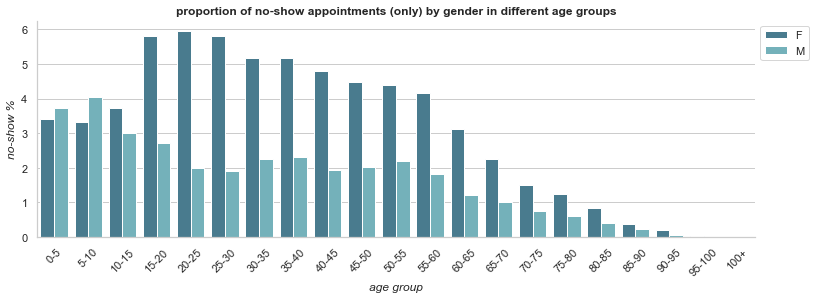

In [279]:
bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110]
labels = ['0-5','5-10','10-15','15-20','20-25','25-30','30-35','35-40','40-45','45-50','50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','90-95','95-100','100+']
no_show_df['age_group'] = pd.cut(no_show_df.age, bins=bins, labels = labels,include_lowest = True)

gender_age = no_show_df.loc[no_show_df['no_show'] == "Yes"]

age_gender = gender_age.groupby(['gender','age_group'], as_index = False)['no_show'].count()
age_gender['%'] = age_gender['no_show']/age_gender['no_show'].sum()*100
age_gender

sns.set(style="whitegrid");
gender_age_noshow_plot = sns.catplot(x="age_group", y="%", hue = 'gender', data=age_gender, kind="bar", palette="GnBu_d", legend_out=False);

gender_age_noshow_plot.fig.set_figwidth(12)
gender_age_noshow_plot.fig.set_figheight(3.6)
gender_age_noshow_plot.set_xticklabels(rotation=45)

plt.title('proportion of no-show appointments (only) by gender in different age groups', fontweight = 'bold')
plt.xlabel('age group', fontstyle='italic');
plt.ylabel('no-show %', fontstyle='italic');
plt.legend(bbox_to_anchor=(1, 1), loc=2);

> The graph above gives us details that are a bit more interesting. The histogram above shows that:

        1. the majority of no-show appointments for female patients occurs between the ages of 15 and 60
        2. the majority of no-show appointments for male patients occurs between the ages of 0-10 and 45-60.

> It's surprising to see such results for infants, particularly considering the greater risk of exposure to diseases that toddlers face due to a weaker immune system. According to the [CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/fields/354.html "CIA World Factbook"), male infants in Brazil have a higher mortality rate than female infants: for every 1,000 live births, there are ~19 male infant deaths, when there are ~13 female infant deaths. In light of such information, we would expect to see a lower no-show rate rather than a higher one. Unfortunately, there is no clear answer here, given the lack of documentation associated with the dataset.

> On the other hand, it's no surprise to see that there's a higher no-show rate for both female and male patients between the ages of 30 and 60. People in that age range are typically healthy and have better immunity than other age groups. As patients get older, the no-show appointment rate decreases significantly. Older patients inevitably experience a decline in their immune functions and an increased exposure to health risks.

> Let's now explore the time difference between the scheduled and appointment days to see whether there exists a correlation between a longer time difference and no-show probability.

### Research Question 2: Is time a significant determinant of no-show appointments?

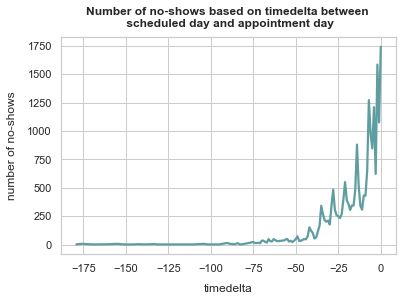

In [280]:
time_slicer = no_show_df.loc[no_show_df['no_show'] == "Yes"]

time_slicer = time_slicer.groupby(['timedelta'], as_index = False)['no_show'].count()


plt.plot( 'timedelta', 'no_show', data=time_slicer, color='cadetblue', linewidth=2.25)
plt.xlabel("timedelta", labelpad=10)
plt.ylabel("number of no-shows", labelpad=10)
plt.title("Number of no-shows based on timedelta between \n scheduled day and appointment day", y=1.02, fontsize=12, fontweight = 'bold');



> Interestingly, the number of no-show appointments increases as the time between the scheduled visit and the medical appointment narrows. It seems like patients who schedule their visit far in advance are extremely reliable, indicative that those patients place importance on their health. They probably also have more serious medical conditions that require tending. However, it is not apparent from the graph above and would require further analysis by examining the various medical conditions associated with the patients that can be found elsewhere in the dataset.

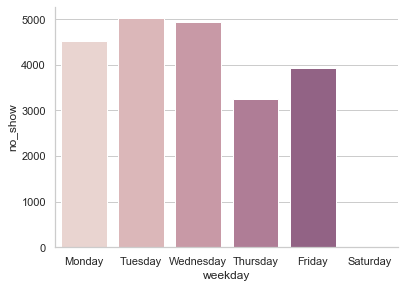

In [281]:
extract_weekday = lambda dt: dt.weekday_name

no_show_df['weekday'] = no_show_df.appointment_day.apply(extract_weekday)

only_no_shows = no_show_df.query('no_show == "Yes"')

only_no_shows = only_no_shows.groupby('weekday',as_index = False)['no_show'].count()

only_no_shows

#re-order weekdays
only_no_shows['weekday'] = pd.Categorical(only_no_shows['weekday'], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
only_no_shows = only_no_shows.sort_values("weekday")
only_no_shows

#plot number of appointments during the week
color = sns.cubehelix_palette(8)
sns.set(style="whitegrid");

only_no_shows_p = sns.catplot(x="weekday", y="no_show", data=only_no_shows, kind="bar", palette=color, legend_out=False);
only_no_shows_p.fig.set_figwidth(6);
only_no_shows_p.fig.set_figheight(4);
only_no_shows_p.set_xticklabels(rotation=0);



> As we can see from the chart above, the days with the most no-shows are Tuesdays and Wednesdays, most likely because those days fall in the middle of the week, when people are the busiest.

<a id='conclusions'></a>
## Conclusions

> After thoroughly cleaning the data by removing 40703 rows, representing approximately 22.6% of the entire dataset, we proceeded to analyze the question whether it is possible to predict the probability of no-show appointments based on certain demographic and temporal information. A lot of the observations made sense, such as the fact that older patients exhibited a lower no-show rate in contrast to adults who exhibited the highest. However, there were some results that were surprising. The patients who scheduled their appointment far in advance are more reliable than those who didn't. A timedelta analysis combined with an analysis of the patients' various medical conditions could certainly lead to even more interesting results. The medical conditions were, however, outside the scope of this analysis.

> One of the main impediments faced during this exercise was the lack of documentation to reliably support some of the findings. There was some pertaining to the 'scholarship' column and a brief explanation of the scoring system for each of the medical conditions. However, there was not enough to understand what caused so many faulty datapoints, what medical facility(ies) were included in the study and what regions or states in Brazil were targeted. Because there isn't enough documentation to understand the scope of the study, it's also hard to develop predictive models based on the no-show appointment dataset alone. It could be interesting to compare this dataset to others that treat the same subject in the same country and understand how far (or close) this dataset is representative of the reality.

### Additional Sources:

* https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

* http://blog.quizzicol.com/2016/10/03/sorting-dates-in-python-by-day-of-week/